# Amazon Fine Food Reviews Analysis with KNN


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive or negative.
We will determine whether a review is positive or negative based on ratings.If score is 1 or 2 then review is negative and if the score is 4 or 5 then review is positive.

Bellow metioned are the steps that we are going to follow:-
 - Data pre-processing step : In this phase we will be performing the following operations:
     - Removal of Stop words.
     - Removal of punctuations marks.
     - Removal of HTML tags.
     - Snow ball stemming of words.
     - Conversion of text into lower case.
     - Using time based splitting, create train and test dataset.
     

 - Create function to find optimal k.
 - Use vectorization methods to convert text into vectors.Bellow mentioned are the methods that we will use:
     - BagOfWords(BOW)
     - Word2Vec
     - tfidf
     - avg. Word2Vec
     - tfidf Word2Vec
     
     
 - On each vectorization method we will be finding optimal K and perform KNN. 
     
     
     





### 1. Load dataset

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [7]:
# using SQLite Table to read data.
con = sqlite3.connect("H:\\AppliedAI\\Assignment\\NaiveBayesAlgoWithAmazonFoodReview\\Amazon Fine Food reviews.sqlite")

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [11]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


# [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...



As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [14]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [17]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [18]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [19]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# [3] Preprocessing
## [3.1]. Preprocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [22]:

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [23]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [24]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [26]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [27]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [28]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

## [3.2a]Preprocessing Review Text

In [29]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████| 87773/87773 [01:20<00:00, 1087.93it/s]


In [30]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

## [3.2b] Preprocessing Review Summary

In [32]:
## preprocessing for review summary 
summary_preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    summary_preprocessed_reviews.append(sentance.strip())

print(summary_preprocessed_reviews[1500])

100%|████| 87773/87773 [01:13<00:00, 1189.96it/s]


hot stuff


## Feature Engineering

In [33]:
# Adding review text and Summary text as Input into the data

preprocessed_reviews = [i + ' ' + j for i, j in zip(preprocessed_reviews,summary_preprocessed_reviews)] 
print(preprocessed_reviews[1500])

way hot blood took bite jig lol hot stuff


## Splitting of Preprocessed data into Train and Test data

In [34]:
#Calculating the train and test size and dividing the data into train and test chunks into the 70 - 30 ratio
import math

preprocessed_reviews = np.array(preprocessed_reviews) 
train_size = math.floor(preprocessed_reviews.shape[0] * 0.7)

#split the data set into train and test
preprocessed_reviews_train = preprocessed_reviews[: train_size]
preprocessed_reviews_test  =preprocessed_reviews[train_size : ]  
Score_train =final['Score'][: train_size ]
Score_test = final['Score'][train_size : ]
print(preprocessed_reviews_train.shape)
print(preprocessed_reviews_test.shape)
# abc = pd.Score_train
# print(abc.value_counts())
print(Score_train.shape)
print(Score_test.shape)
print(Score_train.value_counts())

(61441,)
(26332,)
(61441,)
(26332,)
1    51788
0     9653
Name: Score, dtype: int64


# [4] Featurization

## [4.1] BAG OF WORDS

In [35]:
#BoW 
count_vect = CountVectorizer(min_df=5) #in scikit-learn

# BOW on Train data 
count_vect_train_data = count_vect.fit_transform(preprocessed_reviews_train)

# BOW on Test data  
count_vect_test_data = count_vect.transform(preprocessed_reviews_test)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)


print("the type of count vectorizer of train Preprocessed data",type(count_vect_train_data))
print("the type of count vectorizer of test Preprocessed data",type(count_vect_test_data))
print("the shape of out text BOW vectorizer on train data",count_vect_train_data.get_shape())
print("the shape of out text BOW vectorizer on test data",count_vect_test_data.get_shape())
print("the number of unique words ", count_vect_test_data.get_shape()[1])

some feature names  ['aa', 'aaa', 'aafco', 'aback', 'abandon', 'abandoned', 'abby', 'abc', 'abdomen', 'abdominal']
the type of count vectorizer of train Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer of test Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer on train data (61441, 14349)
the shape of out text BOW vectorizer on test data (26332, 14349)
the number of unique words  14349


## [4.2] Bi-Grams and n-Grams.

In [36]:
#bi-gram, tri-gram and n-gram

n_count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)

# bi-gram BOW on Train data and Test data 
n_count_vect_train_data = n_count_vect.fit_transform(preprocessed_reviews_train) 
n_count_vect_test_data = n_count_vect.transform(preprocessed_reviews_test)


print("some feature names ", n_count_vect.get_feature_names()[:10])
print('='*50)


print("the type of count vectorizer of train Preprocessed data",type(n_count_vect_train_data))
print("the type of count vectorizer of test Preprocessed data",type(n_count_vect_test_data))
print("the shape of out text bi gram BOW vectorizer on train data",n_count_vect_train_data.get_shape())
print("the shape of out text bi gram BOW vectorizer on test data",n_count_vect_test_data.get_shape())
print("the number of unique words ",n_count_vect_train_data.get_shape()[1])

some feature names  ['aa', 'aafco', 'abandon', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer of train Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer of test Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text bi gram BOW vectorizer on train data (61441, 38340)
the shape of out text bi gram BOW vectorizer on test data (26332, 38340)
the number of unique words  38340


## [4.3] TF-IDF 

In [37]:
#Text converting into vector using Tf-Idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10 )

# n-gram TfIdf on Train and Test data 
tfIdf_vect_train_data = tf_idf_vect.fit_transform(preprocessed_reviews_train) 
tfIdf_vect_test_data = tf_idf_vect.transform(preprocessed_reviews_test)

print("some feature names ", tf_idf_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer of train Preprocessed data",type(tfIdf_vect_train_data))
print("the type of count vectorizer of test Preprocessed data",type(tfIdf_vect_test_data))
print("the shape of out text n-gram TfIdf vectorizer on train data",tfIdf_vect_train_data.get_shape())
print("the shape of out text n-gram TfIdf vectorizer on test data",tfIdf_vect_test_data.get_shape())
print("the number of unique words ",tfIdf_vect_train_data.get_shape()[1])

some feature names  ['aa', 'aafco', 'abandon', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer of train Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer of test Preprocessed data <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text n-gram TfIdf vectorizer on train data (61441, 38340)
the shape of out text n-gram TfIdf vectorizer on test data (26332, 38340)
the number of unique words  38340


## [4.4] Word2Vec

In [38]:
# Train your own Word2Vec model using your own text corpus
import gensim

i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

w2v_model=gensim.models.Word2Vec(list_of_sentance,min_count= 5,size=50, workers=4) 

In [39]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = False

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17916
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'dog', 'lover', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V
### [4.4.1.1] Avg W2v

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████| 87773/87773 [07:59<00:00, 183.24it/s]


87773
50


### [4.4.1.2] TFIDF weighted W2v

In [42]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [43]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████| 87773/87773 [1:45:31<00:00, 13.86it/s]


# [5] Apply Naive Bayes
### Functions for Naive Bayes Accuracy

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

#Function to return Optimal value of alpha and Draw plot of area under roc curve vs alpha-
def NaiveBayes_accuracy(Train_data ,Score_train ):
    #possible number of alpha
    alphas =  np.array([0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,30,100,300,1000])
    param_grid = dict(alpha = alphas)
    
    NB_Optimal = MultinomialNB()
    grid = GridSearchCV(NB_Optimal, param_grid=param_grid,scoring='roc_auc',cv=5,  n_jobs=-1)
    grid_result = grid.fit(Train_data , Score_train)
    
    # summarize results
    CV_mean = grid_result.cv_results_['mean_test_score']
    Train_mean = grid_result.cv_results_['mean_train_score']
    
   
    # Plot graph between grid cross validation result and number of neighbors
    plt.plot(np.log10(alphas), CV_mean ,label='AUC of CV data against Alpha' , marker = '*')
    plt.plot(np.log10(alphas) , Train_mean , label='AUC of train data against Alpha' , marker = '*')
    plt.title("Area under Roc Curve vs alpha")
    plt.xlabel('alpha')
    plt.ylabel('Area')
    plt.legend(loc="lower right")
    plt.show()

# Function to  plot graph on area under roc curve on test and train data and print confusion matrix
def plot_Graph(alpha, Train_data, Train_label, Test_data, Test_label):
    #Train KNN on optimal parameter
    NB_Optimal = MultinomialNB(alpha = alpha)
    # fitting the model
    NB_Optimal.fit(Train_data, Train_label)

    #predict the probability of Train data and test data from model
    train_log_proba = NB_Optimal.predict_log_proba(Train_data)
    test_log_proba =  NB_Optimal.predict_log_proba(Test_data)
    
    #Calculate the Class 
    train_pred = np.argmax(train_log_proba, axis=1) 
    test_pred =  np.argmax(test_log_proba, axis=1)
    
    #Compute fpr and tpr from the predicted label and  True label of train data and test data
    fpr_train, tpr_train,_ = roc_curve(Train_label, train_pred)
    fpr_test, tpr_test,_ = roc_curve(Test_label, test_pred)
    
    # Compute area under roc curve
    area_train = auc(fpr_train, tpr_train)
    area_test = auc(fpr_test, tpr_test)
    
    lw =2
    plt.plot(fpr_test, tpr_test, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
    plt.plot(fpr_train, tpr_train, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Area Under Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
     # Confusion matrix for train data
    
    plt.figure()
    cm = confusion_matrix(Train_label, train_pred)
    class_label = ["negative", "positive"]
    df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm_train , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for Train data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
     # Confusion matrix for test data
    
    plt.figure()
    cm = confusion_matrix(Test_label, test_pred)
    class_label = ["negative", "positive"]
    df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    

# Applying Multinomial Naive Bayes 
### [5.1] Applying Naive Bayes on BOW,

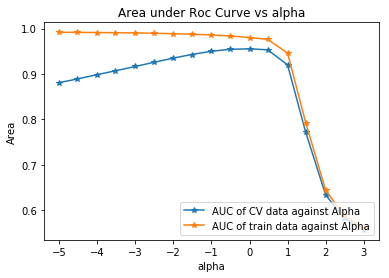

In [46]:
import warnings
warnings.filterwarnings("ignore")

# Find optimal value of aplha
NaiveBayes_accuracy(n_count_vect_train_data , Score_train)

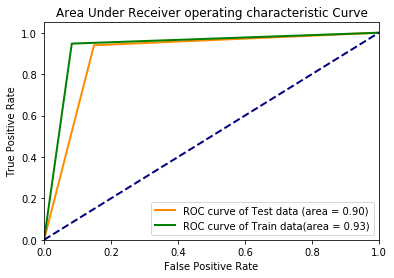

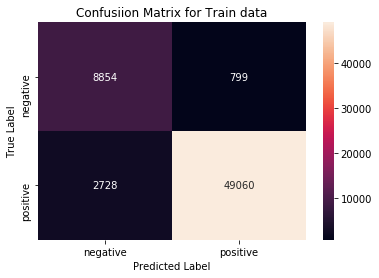

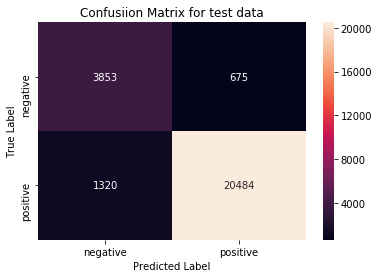

In [47]:
# By looking at the validation and traing curve we can say that
BOW_optimal_alpha = 1.0
#Plot the graph on area under roc curve on test and train data and print confusion matrix
plot_Graph(BOW_optimal_alpha , n_count_vect_train_data, Score_train, n_count_vect_test_data, Score_test)

### [5.1.1] Top 10 important features of positive class from SET 1

In [48]:
# Train model with optimal value of alpha
NB_optimal = MultinomialNB(alpha = BOW_optimal_alpha)
    
# fitting the model
NB_optimal.fit(n_count_vect_train_data, Score_train)

# Top 10 positive  Features After Naive Bayes
pos_class_prob_sorted = NB_optimal.feature_log_prob_[0, :].argsort()
print(np.take(n_count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

['opportunity try' 'good friend' 'buy target' 'buy sure' 'dark cocoa'
 'thermos' 'good gets' 'snack treat' 'buy soon' 'good give']


### [5.1.2] Top 10 important features of Negative class from SET 1

In [49]:
# Top 10 negative Features After Naive Bayes
neg_class_prob_sorted = NB_optimal.feature_log_prob_[1,:].argsort()
print(np.take(n_count_vect.get_feature_names(), neg_class_prob_sorted[:10]))

['let return' 'total rip' 'tasted old' 'formula changed' 'worst ever'
 'flavor awful' 'product misleading' 'bait switch' 'major disappointment'
 'recommend unless']


## [5.2] Applying Naive Bayes on TFIDF, SET 2

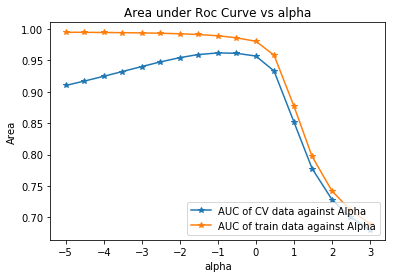

In [50]:
import warnings
warnings.filterwarnings("ignore")

# Find optimal value of aplha
NaiveBayes_accuracy(tfIdf_vect_train_data , Score_train)

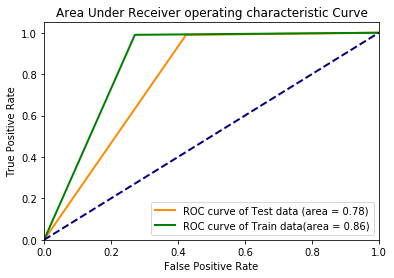

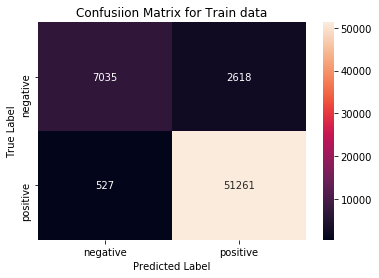

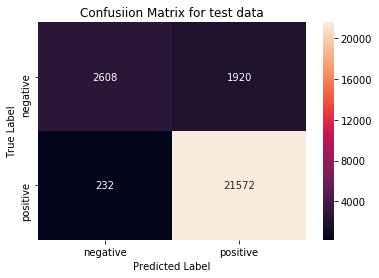

In [51]:
# By looking at the validation and traing curve we can say that
tfIdf_optimal_alpha = 0.1

#Plot the graph on area under roc curve on test and train data and print confusion matrix
plot_Graph(tfIdf_optimal_alpha , tfIdf_vect_train_data , Score_train, tfIdf_vect_test_data , Score_test)

### [5.2.1] Top 10 important features of positive class from SET 2

In [52]:
# Train model with optimal value of alpha
NB_optimal_TfIdf = MultinomialNB(alpha = tfIdf_optimal_alpha)
    
# fitting the model
NB_optimal_TfIdf.fit(tfIdf_vect_train_data , Score_train)

# Top 10 positive  Features After Naive Bayes
pos_class_prob_sorted = NB_optimal_TfIdf.feature_log_prob_[0,:].argsort()
print(np.take(n_count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

['dietary magnesium' 'discounts' 'morning brew' 'times since'
 'discount tommy' 'seasoning ever' 'discontinued carrying' 'morning drink'
 'morning eat' 'times want']


### [5.2.2] Top 10 important features of Negative class from SET 2

In [53]:
# Top 10 negative Features After Naive Bayes
neg_class_prob_sorted = NB_optimal_TfIdf.feature_log_prob_[1, :].argsort()
print(np.take(n_count_vect.get_feature_names(), neg_class_prob_sorted[:10]))

['zero star' 'going trash' 'stuff awful' 'tasted old' 'formula changed'
 'product misleading' 'taste yuck' 'worst ever' 'worst part' 'let return']


# [6] Conclusions

In [55]:
from prettytable import PrettyTable

# Only review text as train data
x = PrettyTable()
x.field_names = ["Algorithm(Review text as Training data Only)", "Optimal value of alpha" , "Train_data_AUC", "CrossValidation_data_AUC", "Test_data_AUC"]
x.add_row(["Naive Bayes with n(1,2) gram BOW  " , 1.0 , 0.91 , 0.937321 , 0.87 ])
x.add_row(["Naive Bayes with TfIdf            " , 0.1 , 0.82 , 0.946352 , 0.74 ])

print(x)



# Both Review text and summary text as the train data 
y = PrettyTable()  
y.field_names = ["Algorithm(Review and Summary text as Training data)", "Optimal value of alpha" , "Train_data_AUC", "CrossValidation_data_AUC", "Test_data_AUC"]
y.add_row(["Naive Bayes with n(1,2) gram BOW  " , 1.0 , 0.93 , 0.95511 , 0.90 ])
y.add_row(["Naive Bayes with TfIdf            " , 0.1 , 0.86 , 0.961842 , 0.78 ])
print(y)

+----------------------------------------------+------------------------+----------------+--------------------------+---------------+
| Algorithm(Review text as Training data Only) | Optimal value of alpha | Train_data_AUC | CrossValidation_data_AUC | Test_data_AUC |
+----------------------------------------------+------------------------+----------------+--------------------------+---------------+
|      Naive Bayes with n(1,2) gram BOW        |          1.0           |      0.91      |         0.937321         |      0.87     |
|      Naive Bayes with TfIdf                  |          0.1           |      0.82      |         0.946352         |      0.74     |
+----------------------------------------------+------------------------+----------------+--------------------------+---------------+
+-----------------------------------------------------+------------------------+----------------+--------------------------+---------------+
| Algorithm(Review and Summary text as Training data) |

**Naive bayes is much better model than Knn model for Text classification for Amazon fine food data**

**When we are train Model with review and summary data as training data, then we are getting slightly higher accuracy than Only Review data as training data.So Feature engineering for Concatenating Summary data into review data work here**

**Naive Bayes with Bow model has more accuracy than TfIdf model here.**

**Naive Bayes with Bow model has optimal value of alpha 1.0 where as Naive Bayes with TfIdf model has optimal value of alpha is 0.1.So for diiferent vectorization of text optimal value may differ.**